In [13]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as v2
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import time

import pandas as pd
from sklearn.metrics import roc_auc_score, confusion_matrix, top_k_accuracy_score, accuracy_score

sns.set_theme()

In [14]:
WIDTH = 224
HEIGHT = 224
NUM_CHANNELS = 3
NUM_CLASSES = 101
NUM_EPOCHS = 10
LR = 3e-4
BATCH_SIZE = 32

In [15]:
def convert_to_rgb(image):
    # If image is not RGB, convert it to RGB
    if image.shape[0] == 1: # Grayscale image
        image = image.repeat(3, 1, 1) # Convert to 3-channel grayscale
    return image

In [16]:
transforms = {
    'train': v2.Compose([
        v2.Resize((WIDTH, HEIGHT)),
        v2.RandomHorizontalFlip(0.2),
        v2.RandomVerticalFlip(0.2),
        v2.ToTensor(),
        v2.Lambda(convert_to_rgb),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]),
    'val': v2.Compose([
        v2.Resize((WIDTH, HEIGHT)),
        v2.ToTensor(),
        v2.Lambda(convert_to_rgb),
        v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        
    ])
}

In [17]:
val_size = 0.2

dataset = datasets.Caltech101(
    root='/datasets',
    download=True,
    transform=transforms['val']
)

val_number = int(len(dataset) * val_size)
train_number = len(dataset) - int(len(dataset) * val_size)

train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_number, val_number])

train_loader = torch.utils.data.DataLoader(batch_size=BATCH_SIZE, shuffle=True, dataset=train_dataset)
val_loader = torch.utils.data.DataLoader(batch_size=BATCH_SIZE, shuffle=True, dataset=val_dataset)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


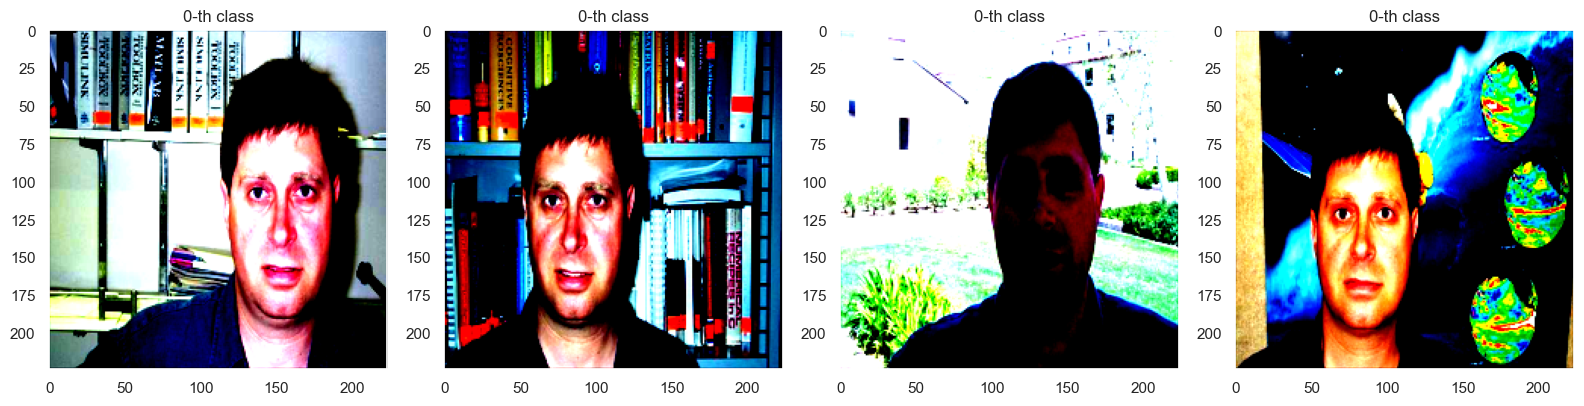

In [18]:
rows = 1
cols = 4

fig, axes = plt.subplots(rows, cols, figsize=(16, 16))

it = iter(dataset)

for i in range(cols):
    img, label = next(it)
    img = img.permute(1, 2, 0).numpy()
        
    axes[i].imshow(img)
    axes[i].set_title(f'{label}-th class')
    axes[i].grid(False)
        
fig.tight_layout()

In [19]:
class MyCnn(nn.Module):
    def __init__(self) -> None:
        super(MyCnn, self).__init__()
        self.model = nn.Sequential(
            # (N, 3, 224, 224)
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),# (N, 64, 224, 224)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # (N, 16, 112, 112),
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding=1), # (N, 32, 112, 112)
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # (N, 32, 56, 56),
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=3, padding=1), # (N, 16, 56, 56)
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout2d(0.2),
            nn.MaxPool2d(kernel_size=2, stride=2), # (N, 16, 28, 28),
            nn.Flatten(),# (N, 50716),
            nn.Linear(in_features=16*28*28, out_features=101), # (N, 101)
            nn.LogSoftmax(dim=1)
        )
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x
    
    def test_model(self):
        x = torch.randn(BATCH_SIZE, NUM_CHANNELS, HEIGHT, WIDTH)
        print(x.shape)
        x = self.model(x)
        print(x.shape)
        assert x.shape == (BATCH_SIZE, NUM_CLASSES)

In [20]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# DEVICE = torch.device('cpu')

my_cnn = MyCnn().to(DEVICE)
optimizer = optim.Adam(params=my_cnn.parameters(), lr=LR)
criterion = nn.NLLLoss()

In [ ]:
history = {
    'train': {
        'roc-auc': [0] * NUM_EPOCHS,
        'top-1 error': [0] * NUM_EPOCHS,
        'auc-rpc': [0] * NUM_EPOCHS,
        'loss': [0] * NUM_EPOCHS,
        'accuracy': [0] * NUM_EPOCHS
    },
    'val': {
        'roc-auc': [0] * NUM_EPOCHS,
        'top-1 error': [0] * NUM_EPOCHS,
        'auc-rpc': [0] * NUM_EPOCHS,
        'loss': [0] * NUM_EPOCHS,
        'accuracy': [0] * NUM_EPOCHS
    }
}

for epoch in range(NUM_EPOCHS):
    start_epoch = time.time()
    
    train_loop = tqdm(enumerate(train_loader), total=(len(train_loader)), desc=f'Train Epoch = {epoch+1}')
    val_loop = tqdm(enumerate(val_loader), total=(len(val_loader)), desc=f'Val Epoch = {epoch+1}')
    
    my_cnn.train()
    
    for batch_idx, (image, label) in train_loop:
        image, label = image.to(DEVICE), label.to(DEVICE)
        output = my_cnn(image)
        
        loss = criterion(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        with torch.no_grad():
            history['train']['loss'][epoch] += loss.item() / len(train_loader)
            pred = torch.argmax(torch.exp(output), axis=1)
            curr_accuracy = accuracy_score(label.detach().cpu().numpy(), pred.detach().cpu().numpy())
            history['train']['accuracy'][epoch] += curr_accuracy / len(train_loader)
            # roc_auc = roc_auc_score(label, torch.exp(output))
            
        train_loop.set_postfix(loss=loss.item(), accuracy=curr_accuracy)
            
            
    my_cnn.eval()
    
    for batch_idx, (image, label) in val_loop:
        image, label = image.to(DEVICE), label.to(DEVICE)
        
        with torch.no_grad():
            output = my_cnn(image)
            loss = criterion(output, label)
            
            history['val']['loss'][epoch] += loss.item() / len(val_loader)
            
            pred = torch.argmax(torch.exp(output), axis=1)
            curr_accuracy = accuracy_score(label.detach().cpu().numpy(), pred.detach().cpu().numpy())
            history['val']['accuracy'][epoch] += curr_accuracy / len(val_loader)
            
        val_loop.set_postfix(loss=loss.item(), accuracy=curr_accuracy)
    
        
    end_epoch = time.time()
        
    print(f"Epoch = {epoch+1}, train loss = {history['train']['loss'][epoch]}, train accuracy = {history['train']['accuracy'][epoch]}")
    print(f"Epoch = {epoch+1}, val loss = {history['val']['loss'][epoch]}, val accuracy = {history['val']['accuracy'][epoch]}")
    print(f"time elapsed = {end_epoch - start_epoch} s")

        
torch.save(my_cnn, f'my_cnn.pth')

Train Epoch = 1: 100%|██████████| 217/217 [00:44<00:00,  4.87it/s, accuracy=0.5, loss=2.89]  

Val Epoch = 1: 100%|██████████| 55/55 [00:51<00:00,  1.07it/s, accuracy=0.429, loss=1.93]


Epoch = 1, train loss = 3.5907715608447384, train accuracy = 0.3306451612903226
Epoch = 1, val loss = 2.4356571782719003, val accuracy = 0.4805194805194805
time elapsed = 51.618107318878174 s


Train Epoch = 2: 100%|██████████| 217/217 [00:46<00:00,  4.67it/s, accuracy=0.567, loss=2.05]

Val Epoch = 2: 100%|██████████| 55/55 [00:53<00:00,  1.02it/s, accuracy=0.429, loss=2.68]


Epoch = 2, train loss = 2.176149354552343, train accuracy = 0.5256528417818737
Epoch = 2, val loss = 2.19204204082489, val accuracy = 0.5350649350649352
time elapsed = 53.76379370689392 s


Train Epoch = 3: 100%|██████████| 217/217 [00:46<00:00,  4.68it/s, accuracy=0.567, loss=1.58] 

Val Epoch = 3: 100%|██████████| 55/55 [00:53<00:00,  1.03it/s, accuracy=0.429, loss=3.02]


Epoch = 3, train loss = 1.5500645272193407, train accuracy = 0.6335157450076818
Epoch = 3, val loss = 2.096259071610191, val accuracy = 0.566314935064935
time elapsed = 53.523975133895874 s


Train Epoch = 4: 100%|██████████| 217/217 [00:46<00:00,  4.69it/s, accuracy=0.767, loss=1.21] 

Val Epoch = 4: 100%|██████████| 55/55 [00:53<00:00,  1.02it/s, accuracy=0.857, loss=0.601]


Epoch = 4, train loss = 1.0433616701359012, train accuracy = 0.7469086021505391
Epoch = 4, val loss = 2.064435405080969, val accuracy = 0.5752435064935068
time elapsed = 53.7074658870697 s


Train Epoch = 5: 100%|██████████| 217/217 [00:46<00:00,  4.66it/s, accuracy=0.767, loss=0.795]

Val Epoch = 5: 100%|██████████| 55/55 [00:54<00:00,  1.01it/s, accuracy=0.429, loss=4.06]


Epoch = 5, train loss = 0.6641448438854259, train accuracy = 0.8367703533026116
Epoch = 5, val loss = 2.1082548802549184, val accuracy = 0.5839285714285716
time elapsed = 54.53844141960144 s


Train Epoch = 6: 100%|██████████| 217/217 [00:46<00:00,  4.69it/s, accuracy=0.867, loss=0.738]

Val Epoch = 6: 100%|██████████| 55/55 [00:54<00:00,  1.02it/s, accuracy=0.286, loss=3.35]


Epoch = 6, train loss = 0.4472858534636588, train accuracy = 0.8932507680491542
Epoch = 6, val loss = 2.067742737856778, val accuracy = 0.5858766233766233
time elapsed = 54.07927227020264 s


Train Epoch = 7: 100%|██████████| 217/217 [00:47<00:00,  4.58it/s, accuracy=0.933, loss=0.415]

Val Epoch = 7: 100%|██████████| 55/55 [00:55<00:00,  1.00s/it, accuracy=0.286, loss=2.76]


Epoch = 7, train loss = 0.2982148971700448, train accuracy = 0.9334485407066035
Epoch = 7, val loss = 2.1028855042024093, val accuracy = 0.5972402597402596
time elapsed = 55.242762088775635 s


Train Epoch = 8: 100%|██████████| 217/217 [00:45<00:00,  4.73it/s, accuracy=0.867, loss=0.246] 

Val Epoch = 8: 100%|██████████| 55/55 [00:54<00:00,  1.02it/s, accuracy=0.286, loss=3.45]


Epoch = 8, train loss = 0.21228795011060042, train accuracy = 0.9543106758832545
Epoch = 8, val loss = 2.2700358737598756, val accuracy = 0.5824675324675325
time elapsed = 54.163676738739014 s


Train Epoch = 9: 100%|██████████| 217/217 [00:46<00:00,  4.69it/s, accuracy=0.967, loss=0.176] 

Val Epoch = 9:  35%|███▍      | 19/55 [00:48<00:05,  6.24it/s, accuracy=0.688, loss=1.83]

In [ ]:
accuracy_df = pd.DataFrame({
    'train accuracy': history['train']['accuracy'],
    'val accuracy': history['val']['accuracy'],
})

loss_df = pd.DataFrame({
    'train loss': history['train']['loss'],
    'val loss': history['val']['loss'],
})

In [ ]:
accuracy_df.plot()

In [ ]:
loss_df.plot()